In [1]:
import torch
from nlp import Dataset
import pandas as pd
import re
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.nn import Softmax
from torch import tensor, where
from torch.utils.data import DataLoader

from random import seed

seed(42)


In [2]:
# read our tweet sample
tweets = pd.read_csv('../data/cleaned_tweets.csv', encoding='ISO-8859-1')

# convert the date to a datetime format
tweets['date'] = pd.to_datetime(tweets['TweetAt']).astype('datetime64[ms]')

# set our index as our datetime column and delete the date columns
tweets.index = tweets['date']
del tweets['date']

# Sort our tweets
tweets.sort_index(inplace=True)

/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13-04-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '14-04-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '25-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: User

In [3]:
# create an index that we can reference later
tweets['index'] = range(tweets.shape[0])

In [4]:
tweets

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label,index
date,,,,,,,,,,
2020-01-04,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1,Overwhelmed with info Before you act stop Ask ...,2,0
2020-01-04,29316,74268,"Fort George G. Meade, Md.",01-04-2020,Malwarebytes rounded up some useful tips for s...,Extremely Positive,1,Malwarebytes rounded up some useful tips for s...,2,1
2020-01-04,29317,74269,Australia,01-04-2020,A Queensland mum has posted a heartbreaking pi...,Extremely Negative,1,A Queensland mum has posted a heartbreaking pi...,0,2
2020-01-04,29318,74270,Debt Jubilee,01-04-2020,New President Trump says U S gasoline prices w...,Neutral,1,New President Trump says U S gasoline prices w...,1,3
2020-01-04,29319,74271,??to Miami,01-04-2020,SUPERMARKET SAFETY is the latest grocery chain...,Extremely Positive,1,SUPERMARKET SAFETY is the latest grocery chain...,2,4
...,...,...,...,...,...,...,...,...,...,...
2020-12-04,42559,87511,U.S.A,12-04-2020,@CNN Pork prices will go up soon they close it...,Neutral,12,Pork prices will go up soon they close it. I g...,1,6837
2020-12-04,42556,87508,"Nevada, USA",12-04-2020,Beware of scammers trying to sell fake vaccine...,Extremely Negative,12,Beware of scammers trying to sell fake vaccine...,0,6838
2020-12-04,42554,87506,"Nabunturan, Davao Region",12-04-2020,Yesterday during the Black Saturday?..\r\r\nat...,Neutral,12,Yesterday during the Black Saturday?..\r\r\nat...,1,6839


In [5]:
# load up a pre-trained bert

BERT_MODEL = 'distilbert-base-uncased'

bert_tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL)


In [6]:
# Grab the same training data as the model_drift notebook
tweets = tweets[:'2020-03']

In [7]:
# Create a Dataset
tweet_dataset = Dataset.from_pandas(tweets.reset_index()[['text', 'label', 'index']])

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# We will pad our dataset so that our input matrices are the same length
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

# map the preprocess function over the dataset
train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label', 'index'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label', 'index'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Define a sequence classification model
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

![title](../images/aum.png)


In [11]:
# https://github.com/asappresearch/aum
from aum import AUMCalculator

# Set a directory to save our results
save_dir = './clean'
# Setting compressed to False gives us information over several epochs
aum_calculator = AUMCalculator(save_dir, compressed=False)

In [12]:
# We are going to define the training process without the training arguments

In [13]:
from transformers import AdamW
from transformers import get_scheduler

# Define our optimizer. Nothing special here
optimizer = AdamW(sequence_classification_model.parameters(), lr=5e-5)
train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

# Train for 10 epochs to get as much data as possible
num_epochs = 10
# Set the number of training steps
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

# Set our model to training mode as opposed to .eval()
sequence_classification_model.train()

for epoch in range(num_epochs):
    # For every epoch, iterate over batches of data
    for batch in train_loader:
        # pass the data into the model without the index column
        _batch = {k: v for k, v in batch.items() if k not in ('index',)}
        _batch['labels'] = _batch['label']  # not very effecient way to change the label name for the siamese network
        del _batch['label']
        outputs = sequence_classification_model(**_batch)
        
        # PyTorch training code
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        
        # Update records in our AUM Calculator
        records = aum_calculator.update(outputs.logits, batch['label'], batch['index'].tolist())
        
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/270 [00:00<?, ?it/s]

In [15]:
# Create the final csvs for analysis
aum_calculator.finalize()

In [16]:
# Read the compressed values
# Lower values are meant to signify potentially mislabeled data
# Higher values are meant to signify potentially properly labelled data
aum_values = pd.read_csv('./clean/aum_values.csv')

# one value per datapoint
print(aum_values.shape)

# Most likely to be labelled correctly
aum_values.head()

(1725, 2)


,sample_id,aum
0,1233,4.334559
1,676,4.326797
2,1193,4.317499
3,70,4.302779
4,820,4.281337


In [17]:
# Most likely to be labelled incorrectly
aum_values.tail()

,sample_id,aum
1720,1199,-2.079528
1721,1913,-2.117557
1722,558,-2.268914
1723,144,-3.019271
1724,538,-3.718345


In [18]:
# Read the uncompressed values over all epochs. 10 values for each datapoint
all_aum_records = pd.read_csv('./clean/full_aum_records.csv')
print(all_aum_records.shape)
all_aum_records.head()

(17250, 8)


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
0,0,1,2,0.578061,0,-0.155418,0.733479,0.733479
1,0,2,2,0.611292,0,-0.139911,0.751203,0.742341
2,0,3,2,1.466129,0,-0.464933,1.931062,1.138581
3,0,4,2,1.983220,1,-1.471889,3.455109,1.717713
4,0,5,2,3.016203,1,-1.644248,4.660451,2.306261


In [19]:
# the highest AUM
highest_sample_aum = int(aum_values.iloc[2].sample_id)

print(highest_sample_aum)

all_aum_records[all_aum_records['sample_id'] == highest_sample_aum]

1193


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
9460,1193,1,2,0.633469,0,-0.446793,1.080262,1.080262
9461,1193,2,2,1.485862,1,-0.804903,2.290765,1.685513
9462,1193,3,2,2.165373,0,-1.387168,3.552541,2.307856
9463,1193,4,2,2.580234,0,-1.545888,4.126122,2.762422
9464,1193,5,2,2.702148,1,-1.718690,4.420838,3.094106
9465,1193,6,2,3.246702,0,-1.968888,5.215590,3.447686
9466,1193,7,2,3.160730,1,-1.991274,5.152003,3.691160
9467,1193,8,2,3.564192,1,-2.225854,5.790047,3.953521
9468,1193,9,2,3.742265,1,-2.339712,6.081977,4.190016
9469,1193,10,2,3.459227,1,-2.005620,5.464847,4.317499


<AxesSubplot:title={'center':'Sample 1193'}>

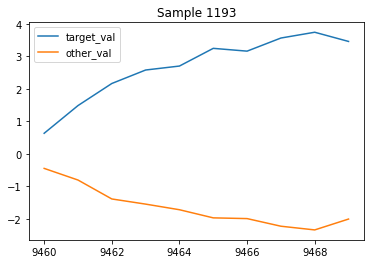

In [20]:
# Plotting the Logit difference between the intended label and the next highest label.
# The target logit is MUCH larger than the next logit which is ideal
all_aum_records[all_aum_records['sample_id'] == highest_sample_aum][['target_val', 'other_val']].plot(
    title=f'Sample {highest_sample_aum}'
)

In [21]:
high_tweet = tweets.iloc[highest_sample_aum]

print(high_tweet['text'])
print(high_tweet['Sentiment'])

retailstrong. Please join us by signing this pledge to support our local retailers during the Covid-19 store closures! We love local retail!  url via
Extremely Positive


In [22]:
# the lowest AUM
lowest_sample_aum = int(aum_values.iloc[-1].sample_id)

print(lowest_sample_aum)

all_aum_records[all_aum_records['sample_id'] == lowest_sample_aum]

538


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
4320,538,1,1,-0.676090,2,0.362087,-1.038177,-1.038177
4321,538,2,1,-0.955007,2,1.005316,-1.960323,-1.499250
4322,538,3,1,-1.589935,2,1.958533,-3.548468,-2.182323
4323,538,4,1,-1.890636,2,2.133163,-4.023799,-2.642692
4324,538,5,1,-1.822263,2,2.934527,-4.756790,-3.065511
4325,538,6,1,-1.659734,2,2.689553,-4.349287,-3.279474
4326,538,7,1,-1.812398,2,2.677097,-4.489495,-3.452334
4327,538,8,1,-1.761161,2,2.151339,-3.912499,-3.509855
4328,538,9,1,-2.257320,2,2.801515,-5.058835,-3.681964
4329,538,10,1,-1.820544,2,2.225235,-4.045779,-3.718345


<AxesSubplot:title={'center':'Sample 538'}>

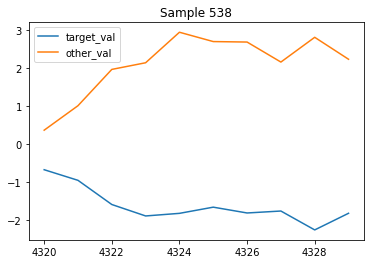

In [23]:
# Plotting the Logit difference between the intended label and the next highest label.
# The next logit is MUCH larger than the target logit which is not ideal
all_aum_records[all_aum_records['sample_id'] == lowest_sample_aum][['target_val', 'other_val']].plot(
    title=f'Sample {lowest_sample_aum}'
)


In [24]:
low_tweet = tweets.iloc[lowest_sample_aum]

print(low_tweet['text'])
print(low_tweet['Sentiment'])

very nice of you not to ask compensation from for causing the SARS virus caused by their overdirty food markets BUT HOW ABOUT this   Demand
Neutral


## Using cosine similarity to find confusing phrases

<img src='https://www.sbert.net/_images/SBERT_Siamese_Network1.png'>

In [25]:
# https://www.sbert.net/docs/usage/semantic_textual_similarity.html

from sentence_transformers import SentenceTransformer, util
# Use a pre-trained model specifically for symmetric semantic text similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

In [26]:
# Embed all tweets into a vector space
embeddings = model.encode(tweets['text'].tolist(), convert_to_tensor=True)

In [27]:
# Calculate cosine similarity for each pair and set a threshold (higher is more semantically similar)
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

COSINE_THRESHOLD = 0.9

In [28]:
# Highlight pairs of tweets that are semantically similar but have different labels
index1, index2 = where(cosine_scores >= COSINE_THRESHOLD)
pairs_to_consider = list(zip(index1.tolist(), index2.tolist()))
for i1, i2 in pairs_to_consider[:len(pairs_to_consider)//2]:
    if i1 != i2:
        samples = tweets[tweets['index'].isin([i1, i2])]
        if samples['Sentiment'].nunique() > 1:
            print(i1, i2, samples[['OriginalTweet', 'Sentiment']].values)
            print('--------')

175 250 [['Covid-19 #heroes: Ã\x82Â\x91The #pub may be closed but that doesnÃ\x82Â\x92t mean we canÃ\x82Â\x92t help peopleÃ\x82Â\x92 https://t.co/RJCkmLDVt5 #coronavirus'
  'Positive']
 ['Covid-19 heroes: Ã\x82Â\x91The pub may be closed but that doesnÃ\x82Â\x92t mean we canÃ\x82Â\x92t help peopleÃ\x82Â\x92\r\r\nhttps://t.co/mpq8VYPrcT #coronavirus positive mindset'
  'Extremely Positive']]
--------
229 440 [["'A Perfect Storm': U.S. Facing Hunger Crisis as Demand for Food Banks Soars https://t.co/wpA6p2XLU7 @theguardian #coronavirus #COVID19 #foodinsecurity"
  'Negative']
 ["'A perfect storm': US facing #hunger #crisis as demand for #foodbanks soars | Environment | The Guardian #ados #pandemic #coronavirus  https://t.co/JboPvSFgLZ"
  'Positive']]
--------
250 175 [['Covid-19 #heroes: Ã\x82Â\x91The #pub may be closed but that doesnÃ\x82Â\x92t mean we canÃ\x82Â\x92t help peopleÃ\x82Â\x92 https://t.co/RJCkmLDVt5 #coronavirus'
  'Positive']
 ['Covid-19 heroes: Ã\x82Â\x91The pub may be clos

# Highlighting a particular pair 

```
1040 [['Need toilet paper Police officers handed out toilet paper rolls at a Sydney supermarket to try to calm panic buying shoppers during the epidemic'
  'Negative']
  
1543 ['Police officers handed out rolls of toilet paper at a Sydney supermarket on Thursday to try to calm shoppers down during the outbreak in Australia'
  'Positive']]
```

In [29]:
# AUM says they are both fairly fine
aum_values[aum_values['sample_id'].isin((1040, 1543))]

,sample_id,aum
1380,1543,2.403288


In [30]:
aum_values['aum'].describe()  # AUM values are low but not crazy low

count    1725.000000
mean        2.876436
std         0.889942
min        -3.718345
25%         2.549786
50%         3.040327
75%         3.437354
max         4.334559
Name: aum, dtype: float64

In [31]:
URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')
def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

In [32]:
# Our model is pretty confident in its predictions
Softmax()(sequence_classification_model(**bert_tokenizer(
    clean_tweet('Need toilet paper Police officers handed out toilet paper rolls at a Sydney supermarket to try to calm panic buying shoppers during the epidemic')
, return_tensors='pt')).logits)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_86658/2031185257.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Softmax()(sequence_classification_model(**bert_tokenizer(


tensor([[0.2264, 0.0267, 0.7469]], grad_fn=<SoftmaxBackward0>)

In [33]:
# Our model is VERY confident in its predictions
Softmax()(sequence_classification_model(**bert_tokenizer(
    clean_tweet('Police officers handed out rolls of toilet paper at a Sydney supermarket on Thursday to try to calm shoppers down during the outbreak in Australia')
, return_tensors='pt')).logits)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_86658/1496898499.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Softmax()(sequence_classification_model(**bert_tokenizer(


tensor([[0.0030, 0.0080, 0.9889]], grad_fn=<SoftmaxBackward0>)

In [34]:
# Our model may be overfitting making it harder to predict unseen data